# Aula 7: Classificação - Árvores, boosting, random forest

Francisco Aparecido Rodrigues, francisco@icmc.usp.br.<br>
Universidade de São Paulo, São Carlos, Brasil.<br>
Copyright (c) 2020.

Nessa aula vamos aprender novos métodos de classificação, que incluem árvores de decisão, métodos baseados em amostragem e florestas aleatórias.

Vamos inicialmente ler os dados:

In [1]:
import random
random.seed(42) # define the seed (important to reproduce the results)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('data/Vehicle.csv', header=(0))

# remove NaN
data = data.dropna(axis='rows') #
# armazena o nome das classes
classes = np.array(pd.unique(data[data.columns[-1]]), dtype=str)  #name of the clases
features_names = data.columns

print("Número de linhas e colunas na matriz de atributos:", data.shape)
attributes = list(data.columns[0:-2])
# mostra os dados
data.head(10)

Número de linhas e colunas na matriz de atributos: (846, 19)


,Comp,Circ,D.Circ,Rad.Ra,Pr.Axis.Ra,Max.L.Ra,Scat.Ra,Elong,Pr.Axis.Rect,Max.L.Rect,Sc.Var.Maxis,Sc.Var.maxis,Ra.Gyr,Skew.Maxis,Skew.maxis,Kurt.maxis,Kurt.Maxis,Holl.Ra,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus
5,107,57,106,172,50,6,255,26,28,169,280,957,264,85,5,9,181,183,bus
6,97,43,73,173,65,6,153,42,19,143,176,361,172,66,13,1,200,204,bus
7,90,43,66,157,65,9,137,48,18,146,162,281,164,67,3,3,193,202,van
8,86,34,62,140,61,7,122,54,17,127,141,223,112,64,2,14,200,208,van
9,93,44,98,197,62,11,183,36,22,146,202,505,152,64,4,14,195,204,saab


Construímos as variáveis $X$ e $y$, sendo que o processo classificação se resume em estimar a função $f$ na relação $y = f(X) + \epsilon$, onde $\epsilon$ é o erro, que tem distribuição normal com média igual a zero e variância $\sigma^2$.

Convertemos para o formato Numpy pra facilitar a manipulação dos dados.

In [2]:
data = data.to_numpy()
nrow,ncol = data.shape
y = data[:,-1]
X = data[:,0:ncol-1]

Vamos normalizar os dados, de modo a evitar o efeito da escala dos atributos.

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

print('Dados transformados:')
print('Media: ', np.mean(X, axis = 0))
print('Desvio Padrao:', np.std(X, axis = 0))

Dados transformados:
Media:  [ 5.87919521e-16 -3.14956886e-16 -3.65349988e-16 -1.67977006e-16
  3.77948264e-17 -1.63777581e-16 -3.56951138e-16  1.72176431e-16
  1.67977006e-17  8.27286755e-16 -9.02876408e-17 -1.46979880e-16
  3.73748839e-16 -6.92905150e-16 -5.24928144e-17 -2.93959761e-17
 -1.31022065e-15  1.52649104e-15]
Desvio Padrao: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Para treinar o classificador, precisamos definir o conjunto de teste e treinamento.

In [4]:
from sklearn.model_selection import train_test_split
p = 0.2 # fracao de elementos no conjunto de teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p, random_state = 42)

A partir desse conjunto de dados, podemos realizar a classificação.

## Árvores de decisão

Árvores de decisão podem ser construidas de diferentes formas, considerando diferentes métodos e medidas, como vimos na aula. Vamos incialmente construir a árvore usando o critério Gini:

In [5]:
from sklearn import tree
# Cria o modelo usando o criterio Gini
model = tree.DecisionTreeClassifier(criterion = 'gini', random_state = 101)
# Ajusta o modelo usando os dados de treinamento
model.fit(x_train,y_train)
# realizar a predição
y_pred = model.predict(x_test) 

Usando a medida de acurácia, avaliamos o desempenho do modelo no aprendizado.

In [6]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.7294117647058823


Podemos visualizar a árvore.

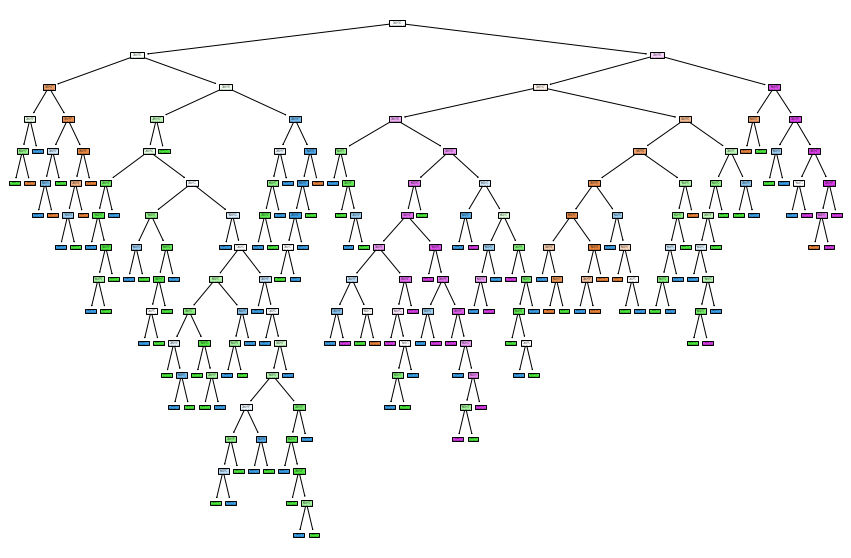

In [7]:
plt.figure(figsize=(15,10))
tree.plot_tree(model.fit(x_train,y_train),filled=True)
plt.show(True)

Se usarmos a medida de entropia:

In [8]:
from sklearn import tree
from sklearn.metrics import accuracy_score

model = tree.DecisionTreeClassifier(criterion = 'entropy',random_state = 101)
model.fit(x_train,y_train)
y_pred = model.predict(x_test) 

score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.7705882352941177


Mostrando a respectiva árvore.

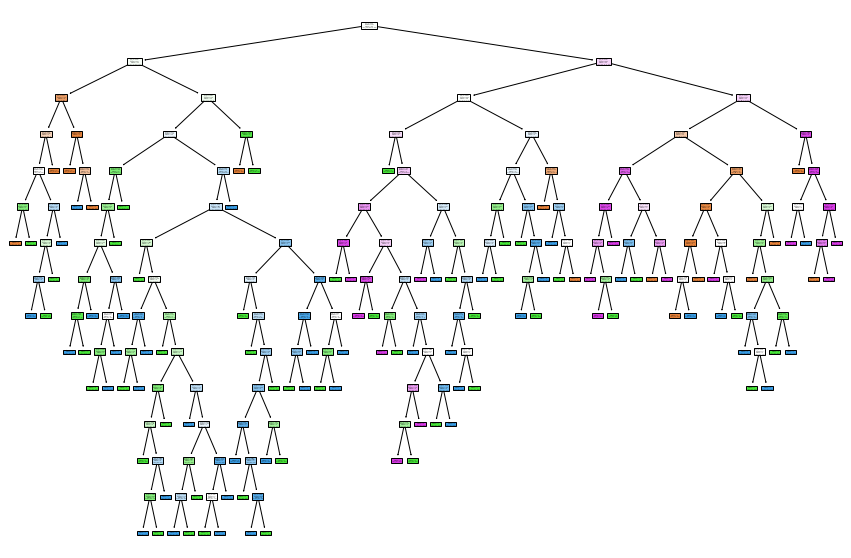

In [9]:
plt.figure(figsize=(15,10))
tree.plot_tree(model.fit(x_train,y_train), filled=True) 
plt.show(True)

Podemos também limitar o tamanho da árvore, o que influencia no resultado:

In [10]:
from sklearn import tree
from sklearn.metrics import accuracy_score

# cria o modelo com número máximo de níveis max_depth
model = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, random_state = 101)
# ajusta aos dados de treinamento
model.fit(x_train,y_train)
# faz a predição usando os dados de teste
y_pred = model.predict(x_test) 
# calcula a acurácia
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.47058823529411764


Visualizando a estrutura da árvore, vemos que há menos níveis do que a anterior.

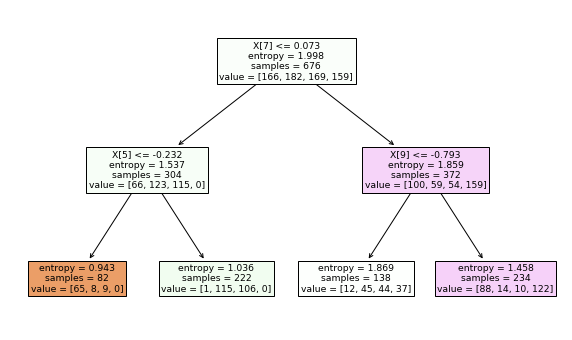

In [11]:
plt.figure(figsize=(10,6))
tree.plot_tree(model.fit(x_train,y_train),filled=True) 
plt.show(True)

Veja a implementação original e estude os parâmetros do modelo: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## Ensemble methods

Emsemble methods permitem diminuir a variância de modelos preditivos. Como vimos na aula, os métodos mais populares são bagging, boosting e random forest. 

A documentação do Scikit-learn relacionada a esses métodos pode ser vista no link: https://scikit-learn.org/stable/modules/ensemble.html

### Bagging

O método bagging (Bootstrap Aggregating) permite que geremos amostrar a partir dos dados iniciais, de modo a reduzir a variância em classificadores com baixo viés. 

A documentação original: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

Vamos realizar a classificação.

In [12]:
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

#chama o classificador
model = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 101),
                          n_estimators=10)
model.fit(x_train,y_train)
# faz a predição no conjunto de teste
y_pred = model.predict(x_test) 
# calcula a acurácia do modelo
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.7470588235294118


Podemos ainda variar o número de estimadores, de modo a verificar com esse parâmetro altera os resultados.

sampe size: 1 Accuracy: 0.7352941176470589
sampe size: 11 Accuracy: 0.7529411764705882
sampe size: 21 Accuracy: 0.7705882352941177
sampe size: 31 Accuracy: 0.7647058823529411
sampe size: 41 Accuracy: 0.7941176470588235
sampe size: 51 Accuracy: 0.788235294117647
sampe size: 61 Accuracy: 0.7823529411764706
sampe size: 71 Accuracy: 0.7705882352941177
sampe size: 81 Accuracy: 0.7823529411764706
sampe size: 91 Accuracy: 0.7764705882352941
*** Melhor n: 41  com acurácia: 0.7941176470588235 ***


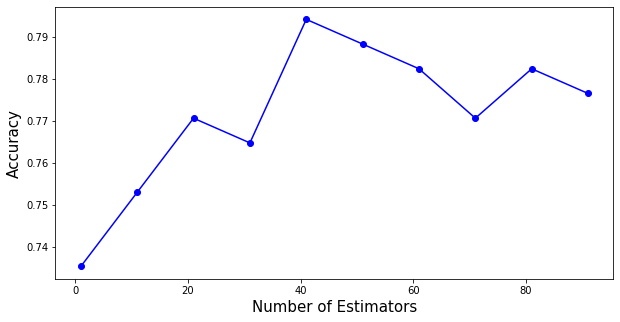

In [13]:
vscore = []
vn = []
# varia o número de estimadores na amostra (número de classificações a serem feitas)
for n in range(1,100,10):
    model = BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(criterion = 'entropy'),
                              n_estimators=n, random_state = 101)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test) 
    score = accuracy_score(y_pred, y_test)
    print('sampe size:', n, 'Accuracy:', score)
    vscore.append(score)
    vn.append(n)
best_n = vn[np.argmax(vscore)]
print('*** Melhor n:', best_n, ' com acurácia:', vscore[np.argmax(vscore)],'***')
plt.figure(figsize=(10,5))
plt.plot(vn, vscore, '-bo')
plt.xlabel('Number of Estimators', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show()

Notem que a geração de novas amostras melhora os resultados em relação à uma árvore, como feito anteriormente. Vamos mostrar o código novamente.

In [14]:
from sklearn import tree
from sklearn.metrics import accuracy_score
import random
random.seed(42) # define the seed 

model = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 101)
model.fit(x_train,y_train)
y_pred = model.predict(x_test) 

score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.7705882352941177


### Boosting

Boosting é outra técnica importante para diminuirmos a variância nos dados. A diferença entre essa técnica e a bagging pode ser resumida na figura abaixo. No caso da boosting, a ideia é selecionar os dados não de forma aleatória, mas priorizar os casos que foram mais difíceis de classificar.
<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1542651255/image_2_pu8tu6.png">

Fazendo a classificação usando AdaBoosting:

In [15]:
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1, 
                         base_estimator=tree.DecisionTreeClassifier(criterion = 'entropy'))
# Train Adaboost Classifer
model = abc.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(x_test)
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.7529411764705882


Podemos ainda variar o número de estimadores, de modo a verificar com esse parâmetro altera os resultados.

Number of estimators 1 Accuracy: 0.7529411764705882
Number of estimators 11 Accuracy: 0.7588235294117647
Number of estimators 21 Accuracy: 0.7470588235294118
Number of estimators 31 Accuracy: 0.7588235294117647
Number of estimators 41 Accuracy: 0.7647058823529411
Number of estimators 51 Accuracy: 0.7705882352941177
Number of estimators 61 Accuracy: 0.7764705882352941
Number of estimators 71 Accuracy: 0.7647058823529411
Number of estimators 81 Accuracy: 0.7705882352941177
Number of estimators 91 Accuracy: 0.7647058823529411
*** Melhor n: 61  com acurácia: 0.7764705882352941 ***
Melhor n: 61  com acurácia: 0.7764705882352941


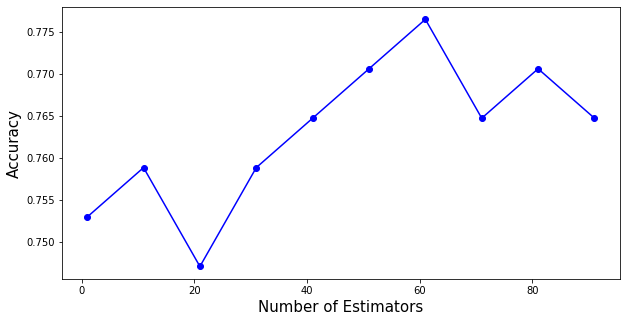

In [16]:
vscore = []
vn = []
for n in range(1,100,10):
    model = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(criterion = 'entropy'),n_estimators=n)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test) 
    score = accuracy_score(y_pred, y_test)
    print('Number of estimators', n, 'Accuracy:', score)
    vscore.append(score)
    vn.append(n)
best_n = vn[np.argmax(vscore)]
print('*** Melhor n:', best_n, ' com acurácia:', vscore[np.argmax(vscore)],'***')
best_n = vn[np.argmax(vscore)]
print('Melhor n:', best_n, ' com acurácia:', vscore[np.argmax(vscore)] )
plt.figure(figsize=(10,5))
plt.plot(vn, vscore, '-bo')
plt.xlabel('Number of Estimators', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show()

### Random Forest

O método florestas aleatórias considera amostragem de observações e atributos. Vamos realizar a classificação.

In [17]:
from sklearn.ensemble import RandomForestClassifier

# define os parâmetros do modelo
model=RandomForestClassifier(n_estimators=100, bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = model.predict(x_test)
score = accuracy_score(y_pred, y_test)
print('Accuracy:', score)

Accuracy: 0.7588235294117647


Estudo os atributos do método: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Podemos analisar como o número de árvores influencia no resultado.

Number of Estimators: 1 Accuracy: 0.6823529411764706
Number of Estimators: 11 Accuracy: 0.7470588235294118
Number of Estimators: 21 Accuracy: 0.7470588235294118
Number of Estimators: 31 Accuracy: 0.7529411764705882
Number of Estimators: 41 Accuracy: 0.7529411764705882
Number of Estimators: 51 Accuracy: 0.7411764705882353
Number of Estimators: 61 Accuracy: 0.7705882352941177
Number of Estimators: 71 Accuracy: 0.7705882352941177
Number of Estimators: 81 Accuracy: 0.7588235294117647
Number of Estimators: 91 Accuracy: 0.7588235294117647
Melhor n: 61  com acurácia: 0.7705882352941177


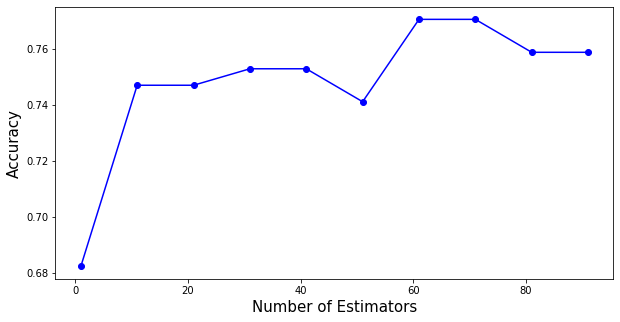

In [18]:
vscore = []
vn = []
for n in range(1,100,10):
    model = RandomForestClassifier(n_estimators=n)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test) 
    score = accuracy_score(y_pred, y_test)
    print('Number of Estimators:', n, 'Accuracy:', score)
    vscore.append(score)
    vn.append(n)
best_n = vn[np.argmax(vscore)]
print('Melhor n:', best_n, ' com acurácia:', vscore[np.argmax(vscore)] )
plt.figure(figsize=(10,5))
plt.plot(vn, vscore, '-bo')
plt.xlabel('Number of Estimators', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show()

O algoritmo radom forest permite ainda quantificar a importância de cada variável na classificação. Quanto maior esse valor, mais o atributo influencia na classificação. Vejam que a soma dos pesos é igual a um.

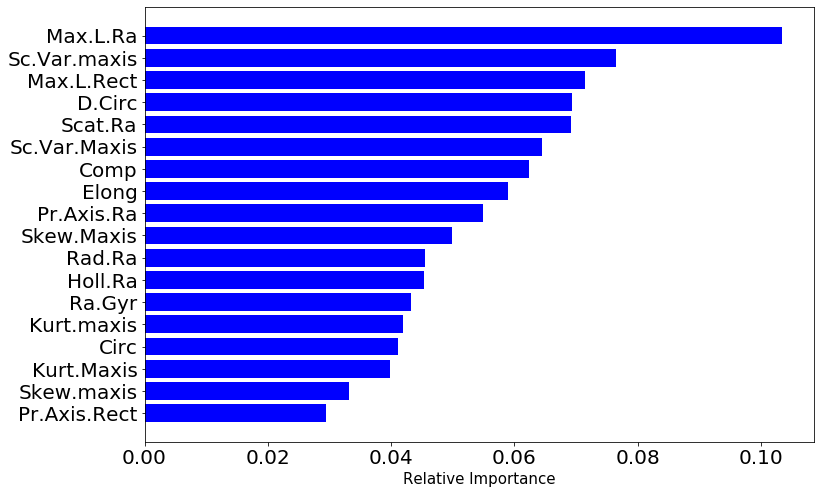

In [19]:
importances = model.feature_importances_
indices = np.argsort(importances)
lmeas_order = []
for i in indices:
    lmeas_order.append(features_names[i])
plt.figure(figsize=(12,8))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), lmeas_order, fontsize=15)
plt.xlabel('Relative Importance',fontsize=15)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.show()

Com isso, podemos fazer uma ordenação dos atributos e selecionar apenas os mais importantes.

### Região de decisão

Vamos visualizar a região de decisão de uma foresta aleatória.

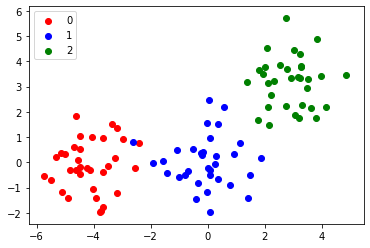

In [20]:
import sklearn.datasets as skdata
from matplotlib import pyplot
from pandas import DataFrame
# generate 2d classification dataset
n_samples = 100
centers = [(-4, 0), (0, 0), (3, 3)]
X, y = skdata.make_blobs(n_samples=100, n_features=2, cluster_std=1.0, centers=centers, 
                         shuffle=False, random_state=42)

# cria a matriz de atributos
d = np.column_stack((X,np.transpose(y)))
# transforma os dados para o formato dataframe do pandas
data = DataFrame(data = d, columns=['X1', 'X2', 'y'])
features_names = ['X1', 'X2']
class_labels = np.unique(y)
#Plotting
colors = ['red', 'blue', 'green', 'black']
aux = 0
for c in class_labels:
    ind = np.where(y == c)
    # mostra os grupos com diferentes cores
    plt.scatter(X[ind,0][0], X[ind,1][0], color = colors[aux], label = c)
    aux = aux + 1
plt.legend()
plt.show()

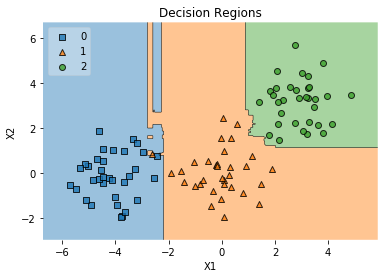

In [21]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

# Training a classifier
model=RandomForestClassifier(n_estimators=100, bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model.fit(X, y)
# Plotting decision regions
plot_decision_regions(X, y, clf=model, legend=2)
# Adding axes annotations
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Regions')
plt.show()

### Exercícios de fixação

Não é necessário entregar os exercícios abaixo, mas é importante resolvê-los para fixar os conteúdos estudados.

1 - Repita todos os passos acima para a base de dados BreastCancer.

2 - Compare os metodos de classificação vistos nessa aula para a base vertebralcolumn-3C.

3 - Em um mesmo gráfico, mostre a acurácia em função do tamanho da amostra para os métodos bagging, boosting e random forest. Considere a base de dados vertebralcolumn-3C.

4 - Considerando a base de dados Vehicle, projete os dados em duas dimensões usando PCA e mostre as regiões de separação como feito acima.

5 - Faça a classificação dos dados gerados artificialmente com o código abaixo. Compare os resultados para os métodos vistos nessa aula.

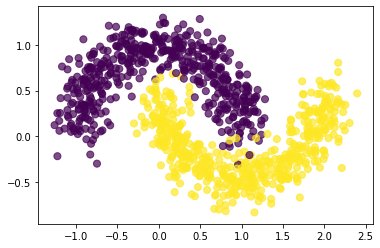

In [22]:
from sklearn import datasets
plt.figure(figsize=(6,4))

n_samples = 1000

data  = datasets.make_moons(n_samples=n_samples, noise=.15)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.show(True)

5 - Encontre a região de separação dos dados do exercício anterior usando Random Forest e Bagging.